# Computing the Perspective Transformation Parameters

This notebook provides a brief description of how to compute the perspective transformation matrices and conversion factors between pixels and meters required by the lane tracker.

---
## 0. Import Modules, Load Camera Matrix

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from utils import load_camera_calib

%matplotlib inline

In [2]:
cam_matrix, dist_coeffs = load_camera_calib('cam_calib.p')

Camera matrix and distortion coefficients loaded.


---
## 1. Compute Perspective Transformation

The goal of the perspective transformation is to create bird's eye view versions of images recorded by a camera mounted on a vehicle. For the lane tracker to work correctly, it needs to see the ground plane (i.e. the road) perpendicularly from above. In order compute this transformation, we'll take an image recorded with the mounted camera while the vehicle is on a flat, straight road with clear lane lines.

This perspective transformation is a linearization of the true surface, i.e. we're pretending that the surface that the vehicle is driving on is a perfect plane that is at all times parallel to the velocity vector of the vehicle. In reality, of course, the surface is not a plane. Whenever there are hills or bumps in the road, the perspective transformation we compute here will be a poor approximation to the true perpendicular view from above. To be more precise, whenever the slope of the road ahead changes, the perspective transform fails to truly show the surface perpendiculalry from above as long as the change rate of the slope is non-zero.

This approach has a number of shortcomings. The surface is not flat, the road and its lane lines are not perfectly straight, and the car and its camera are not oriented perfectly along the direction of the lane. Despite these shortcomings, this approximation is the best we have without having to build a much more complex system.

The procedure for the calibration is this:

1. Pick an image recorded with the mounted camera while the vehicle is on a flat, straight road with clearly visible lane lines. It is important that the road is as close to flat as possible and that the lane lines are as close to straight as possible. Ideally, the camera is in the center of the lane and oriented perfectly along the direction of the lane.
2. Pick two points on each of the two lane lines such that the four points form a trapezoid with bases parallel to the horizontal axis of the image. This is the set of source points for the transform.
3. Pick four points that form a rectangle. This is the set of destination points for the transform, i.e. the transform will be computed as a linear transformation (i.e. a matrix) that maps the source points onto the destination points.
4. Call `cv2.getPerspectiveTransform()` with the source and destination points to compute the transformation matrix.
5. Call `cv2.getPerspectiveTransform()` with the source and destination points in reverse order to compute the inverse transformation matrix. We will need this to transform detected lane lines back to the original view after processing.
6. Choose a size (width, height) for the transformed image.
7. Call `cv2.warpPerspective()` with the calibration image and the transformation matrix.
8. If the transformed image contains a suitable stretch of the road ahead and displays the lane lines as nearly parallel, the transformation matrix computed in step 4 is usable. If not, tune the source points, destination points and/or the output size of the transformed image and repeat the procedure.

A note about the last step: You will want to make sure that the transformation makes the lane lines (close to) parallel, granted that the road in the input image is (close to) straight. In order detect and project lane lines for a meaningful stretch of the road ahead, you will also want to make sure that the transformed image contains a long enough stretch of the road. Lastly, the lane tracker works better the more straight the lane lines are. In order to make the lane tracker work better on sharp turns, it helps to stretch out the transformed image vertically so that curved lane lines become a bit more straight. This transformation is neutral, as the lane lines found in the transformed image will be transformed back to the original view after processing using the inverse of the transformation matrix.

The cells below perform the steps explained above on an example image.

---

First, we'll define a small helper function that takes as input an image and a set of vertices and draws a polygon onto the image. This helps visualize our choice of source points and identify problems in the transformed image.

In [9]:
# Define a helper function to visualize the trapezoid of warp points
# on the image to make sure the warp points are chosen accurately.

def draw_polygon(img, vertices, color=[255, 0, 0], thickness=2):
    output = np.copy(img)
    for i in range(len(vertices)-1):
        cv2.line(output, vertices[i], vertices[i+1], color, thickness)
    cv2.line(output, vertices[len(vertices)-1], vertices[0], color, thickness)
    return output

Before we compute the transform, it is always a good idea to rectify the calibration image of any distortion. Using a camera matrix and distortion coefficient for your camera, undistort the calibration image as below.

In [14]:
# Load images for perspective warp calibration and display the chosen vertices.

# Load and undistort the calibration image. This example image has a size of 1280x720
calib_image = cv2.undistort(mpimg.imread('test_images/straight_lines1.jpg'), cam_matrix, dist_coeffs, None, cam_matrix)

# Choose source points...
vertices = [(242,695),
            (564,473),
            (721,473),
            (1064,695)]

# ...and draw them onto the image. Adjust the source points and repeat this step until you have a good set of source points.
calib_image_trapezoid = draw_polygon(calib_image, vertices)

src = np.array(vertices, np.float32)

# Choose destination points.
dst = np.array([[439,1100],
                [439,380],
                [643,380],
                [643,1100]], np.float32)

# Compute the transformation matrix...
M = cv2.getPerspectiveTransform(src, dst)
# ...and its inverse.
Minv = cv2.getPerspectiveTransform(dst, src)

# Check what the transformed image looks like. The chosen output size for this example is 1080x1100
warped_calib_image_trapezoid = cv2.warpPerspective(calib_image_trapezoid, M, (1080,1100), flags=cv2.INTER_LINEAR)

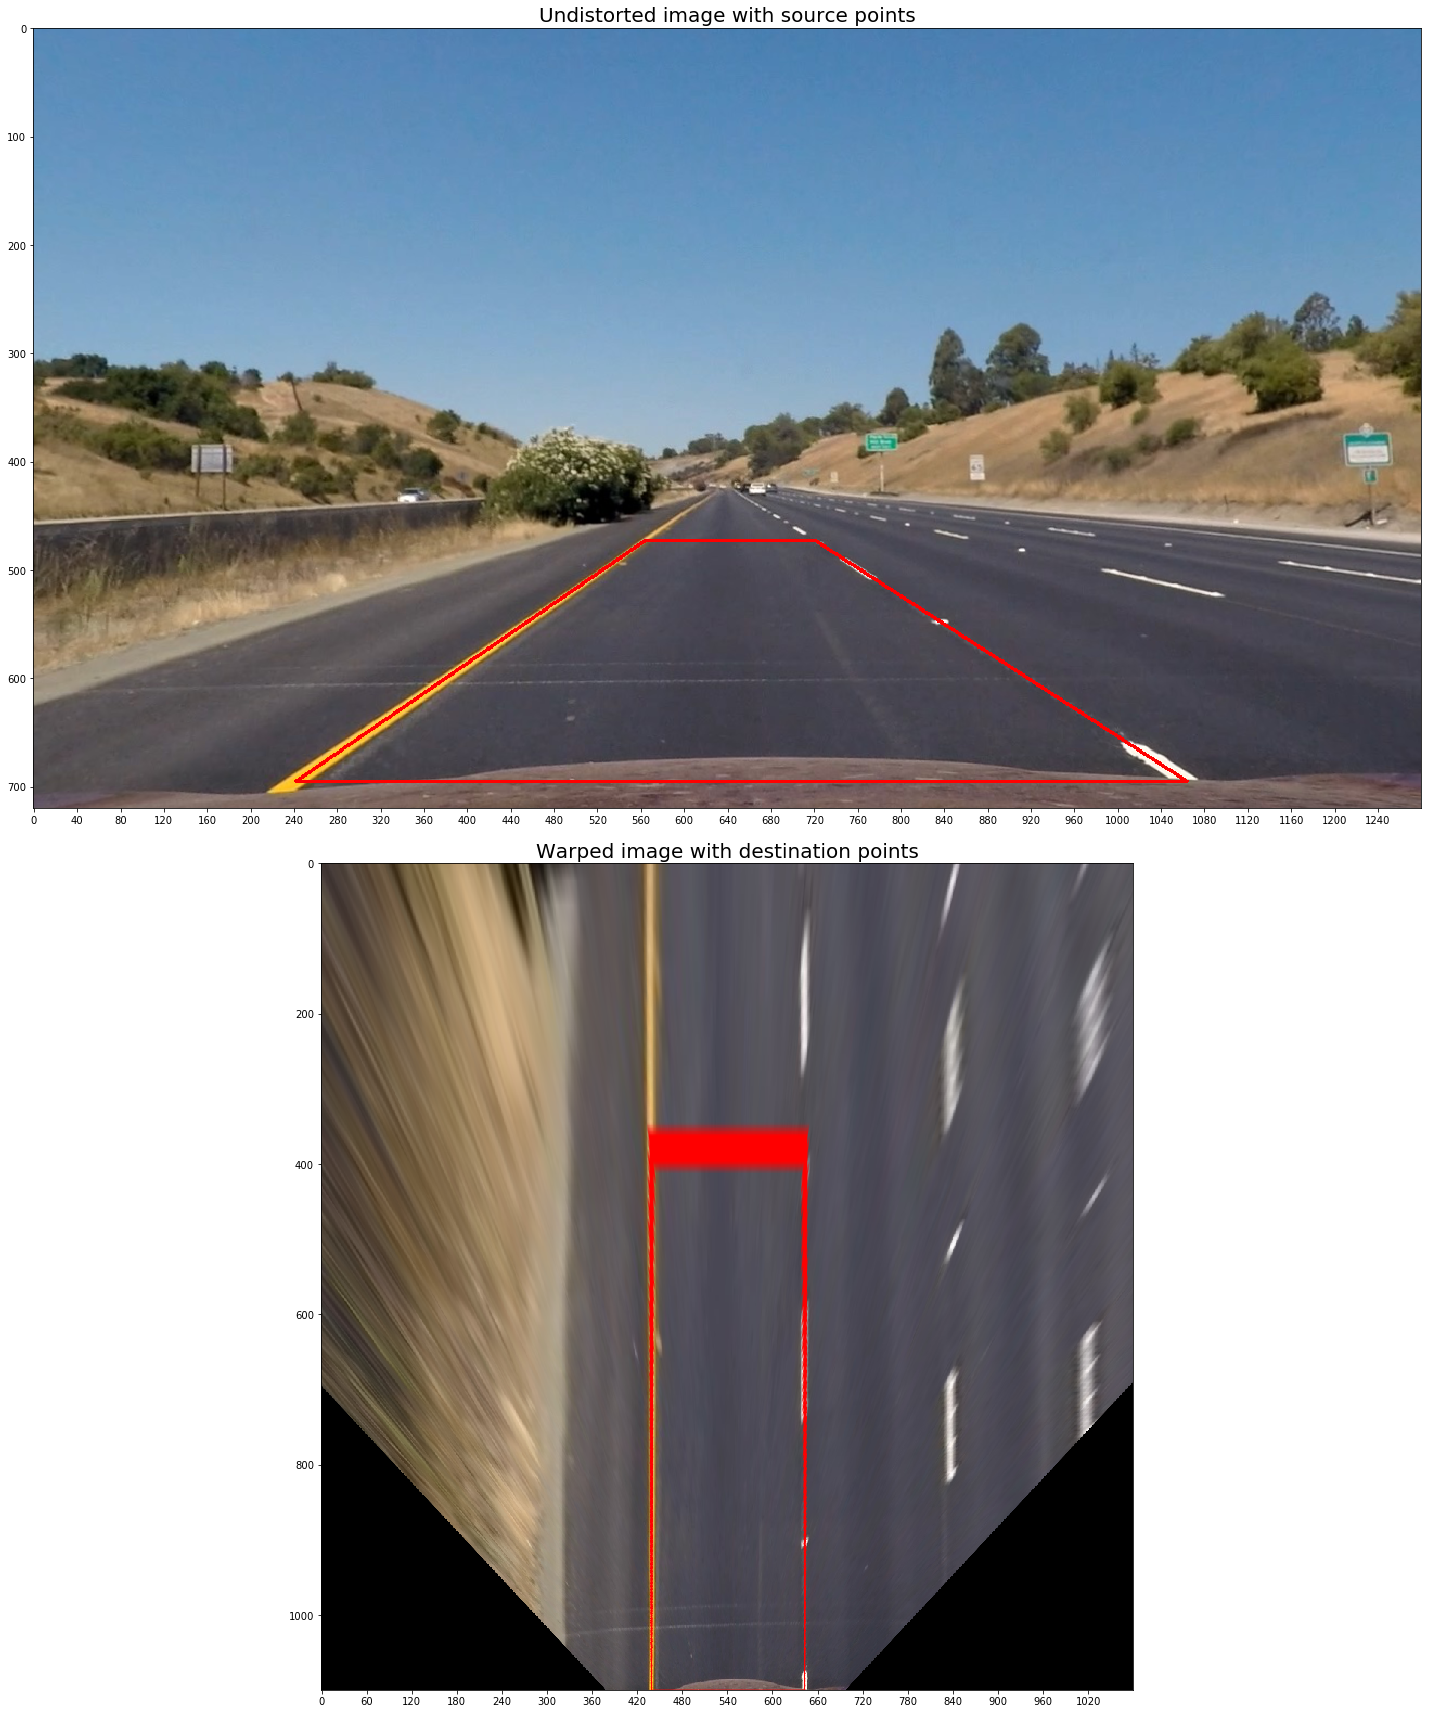

In [15]:
# Plot the results

f, axes = plt.subplots(2, 1, figsize=(20, 24))
f.tight_layout()
axes[0].imshow(calib_image_trapezoid)
axes[0].set_title('Undistorted image with source points', fontsize=20)
axes[0].set_xticks(range(0, 1280, 40)); # Semicolon suppresses output
axes[1].imshow(warped_calib_image_trapezoid)
axes[1].set_title('Warped image with destination points', fontsize=20)
axes[1].set_xticks(range(0, 1080, 60));

---
## 2. Compute Metric Conversion

The cell below computes an approximate conversion of pixels to meters. This conversion is used to compute the curve radius and the deviation of the vehicle from the center of the lane. The lane tracker will work without it, but then you won't have a meaningful estimation of these two metrics. Not that the way we are estimating the conversion factors here or the way the curvature of the lane is computed is accurate anyway, but it's a barely acceptable approximation.

The procedure to estimate the metric conversion factors is this:

1. From the transformed (warped) image, slice out a patch that has the width of the lane and the length of one dashed white lane line.
2. Compute the ratio of the width of the lane in meters and the width of the patch in pixels.
2. Compute the ratio of the length of the dashed white lane line in meters and the height of the patch in pixels.

This procedure requires knowledge of the width of the lane and the length of the dashed white lane line. If you cannot measure these metrics in the field, it might be a good enough approximation to look up the standardized lane widths and dashed line lengths for your respective country. The example image used above was recorded on a US highway, where the minimum lane width required by regulations is 12 feet, or approximately 3.66 meters, and the length of a dashed white lane line is 10 feet, or approximately 3.05 meters.

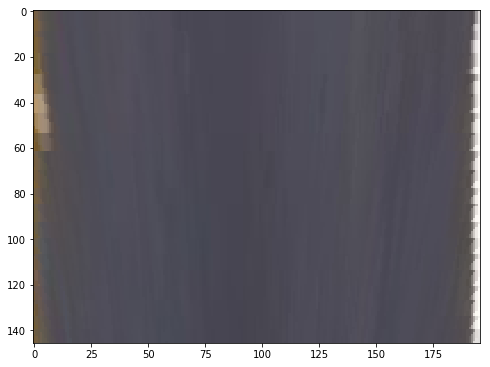

In [22]:
# Do a quick & dirty computation of the metric measurements in our warped images

# Warp the calibration image without the trapezoid drawn onto it
warped_calib_image = cv2.warpPerspective(calib_image, M, (1080,1100), flags=cv2.INTER_NEAREST)

# Slice out a patch that has the width of the lane and the length of one dashed white lane line
measurement_patch = warped_calib_image[594:740,446:642]

h = measurement_patch.shape[1]
v = measurement_patch.shape[0]

mpph = 3.66/h # meters per pixel horizontally
mppv = 3.05/v # meters per pixel vertically

plt.figure(figsize=(8,8))
plt.imshow(measurement_patch);

Now save all these parameters to disk. The format below is how the lane tracker expects the parameters.

In [ ]:
# Save the warp parameters to disk
warp_params = {"M": M,
               "Minv": Minv,
               "image_width_height": (1280,720),
               "warped_width_height": (1080,1100),
               "mppv": mppv,
               "mpph": mpph}
with open("warp_params.p", "wb") as f:
    pickle.dump(warp_params, f)